In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

import glob

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Avalanche Capstone
Notebook Author: Sean Simkus  
Date: June 27, 2021  
For: BrainStation

Requires data from webscraper.ipynb please run that notebook before this one.

# Loading the Data

The second part of the data collection requires collecting weather data to match the avalanche incidents and creating data for the non-avalanche class.  

We have already collected all the avalanche information we need from the web scraper, so we will load the data and cross-reference it with the weather station data to find the closest weather station to the avalanche. Once we have the nearest station, we will get weather information for that day by doing a bulk download from the Canadian government's historical weather data.

In [2]:
# Get the dataframe from the avalanche records
avalanche_df = pd.read_csv('data/avalanche.csv', index_col=0)

## Avalanche Data
Each of the 2450 rows in `avalanche_df` represents an avalanche report as found on the Mountain Information Network from the [Avalanche Canada website](https://www.avalanche.ca/mountain-information-network/submissions).  
  
  
**Data Dictionary**  
- `Location` : The latitude and longitude of the avalanche
- `date_occured` : The time the report was created

Due to users being able to report the evidence of an avalanche, some of the avalanches could have happened a day before they were reported and will not have the correct weather data associated with when the avalanche occurred. This will affect the validity of my modelling and will need to be factored into the results. 


In [3]:
# Check the shape of the avalanche data
print(f'avalanche_df has {avalanche_df.shape[0]} rows and {avalanche_df.shape[1]} columns')

avalanche_df has 2450 rows and 2 columns


In [4]:
# Examine the data
avalanche_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2450 entries, 0 to 2449
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      2450 non-null   object
 1   date_occured  2450 non-null   object
dtypes: object(2)
memory usage: 57.4+ KB


In [5]:
# Look the data
avalanche_df.head(5)

,location,date_occured
0,59.713938° N 135.095702° W,"Thursday, May 27, 2021, 14:00"
1,51.171303° N 116.051255° W,"Saturday, May 22, 2021, 09:00"
2,50.427560° N 122.473110° W,"Sunday, May 16, 2021, 11:00"
3,51.394930° N 116.265450° W,"Saturday, May 15, 2021, 12:00"
4,51.395059° N 116.257463° W,"Friday, May 14, 2021, 12:30"


This data will need to be split up later on after we finish loading the rest of the data and move onto the data transformation section.

## Weather Station Data
The Canadian Government provides a CSV of all the weather stations the keep records of in a google drive located [here](https://drive.google.com/drive/folders/1WJCDEU34c60IfOnG4rv5EPZ4IhhW9vZH).  This CSV contains the location in latitude and longitude for each station and the name and unique identifier for each station. These station are what we will use to get the weather data later on.

**Data Dictionary**  
  
 - `Name` : The name of the station  
 - `Province` : The province the station is located in  
 - `Climate ID` : The main identification id for the station  
 - `Station ID` : The ID used by the Canada Government website  
 - `WMO ID` : An Identification number  
 - `TC ID` : Another Identification number  
 - `Elevation (m)` : The elevation of the station  
 - `HLY First Year` : First year hourly reporting was available   
 - `HLY Last Year` : Last year hourly reporting was available  
 - `DLY First Year` : First year daily reporting was available   
 - `DLY Last Year` : Last year daily reporting was available  
 - `First Year`: First year the station was operations  
 - `Last Year` : Last year the station was operations  
 - `MLY First Year` : First year monthly reporting was available   
 - `MLY Last Year` : Last year monthly reporting was available  
 - `Latitude` : The latitude of the station  
 - `Longitude` : The longitude of the station  
 - `Latitude (Decimal Degrees)` : The latitude of the station in decimal degrees  
 - `Longitude (Decimal Degrees)` : The longitude of the station in decimal degrees  

In [6]:
# Get a dataframe from the list of stations.
station_df = pd.read_csv('Data\Station Inventory EN.csv')

In [7]:
print(f'station_df has {station_df.shape[0]} rows and {station_df.shape[1]} columns')

station_df has 8775 rows and 19 columns


As we can see, 8775 stations are or have been tracked across Canada. However, not all of these stations are still active, or report daily. Therefore, we will need to filter down the daily reports from 2016 to 2021. Filtering can be achieved by setting maximum and minimum values for `DLY Last Year` and `DLY First Year`, respectively. These two columns refer to the years that daily weather readings that were available.

In [8]:
# look at the data
station_df.head()

,Name,Province,Climate ID,Station ID,WMO ID,TC ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Latitude,Longitude,Elevation (m),First Year,Last Year,HLY First Year,HLY Last Year,DLY First Year,DLY Last Year,MLY First Year,MLY Last Year
0,ACTIVE PASS,BRITISH COLUMBIA,1010066,14,NaN,NaN,48.87,-123.28,485200000,-1231700000,4.0,1984,1996,NaN,NaN,1984.0,1996.0,1984.0,1996.0
1,ALBERT HEAD,BRITISH COLUMBIA,1010235,15,NaN,NaN,48.40,-123.48,482400000,-1232900000,17.0,1971,1995,NaN,NaN,1971.0,1995.0,1971.0,1995.0
2,BAMBERTON OCEAN CEMENT,BRITISH COLUMBIA,1010595,16,NaN,NaN,48.58,-123.52,483500000,-1233100000,85.3,1961,1980,NaN,NaN,1961.0,1980.0,1961.0,1980.0
3,BEAR CREEK,BRITISH COLUMBIA,1010720,17,NaN,NaN,48.50,-124.00,483000000,-1240000000,350.5,1910,1971,NaN,NaN,1910.0,1971.0,1910.0,1971.0
4,BEAVER LAKE,BRITISH COLUMBIA,1010774,18,NaN,NaN,48.50,-123.35,483000000,-1232100000,61.0,1894,1952,NaN,NaN,1894.0,1952.0,1894.0,1952.0


In [9]:
# Create a dataframe from stations that had daily reports from 2016-2021
station_2016_df = station_df[(station_df['DLY Last Year'] >= 2020) & (station_df['DLY First Year'] <= 2016)]

In [10]:
# Check
station_2016_df.head()

,Name,Province,Climate ID,Station ID,WMO ID,TC ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Latitude,Longitude,Elevation (m),First Year,Last Year,HLY First Year,HLY Last Year,DLY First Year,DLY Last Year,MLY First Year,MLY Last Year
12,CHEMAINUS,BRITISH COLUMBIA,1011500,26,NaN,NaN,48.94,-123.74,485606080,-1234430000,75.00,1919,2021,NaN,NaN,1919.0,2021.0,1919.0,2007.0
26,LAKE COWICHAN,BRITISH COLUMBIA,1012055,40,NaN,NaN,48.83,-124.05,484946000,-1240308000,171.00,1960,2021,NaN,NaN,1960.0,2021.0,1960.0,2007.0
28,DISCOVERY ISLAND,BRITISH COLUMBIA,1012475,27226,71031.0,WDR,48.42,-123.23,482528590,-1231332519,18.93,1997,2021,1997.0,2021.0,1997.0,2021.0,1998.0,2005.0
39,ESQUIMALT HARBOUR,BRITISH COLUMBIA,1012710,52,71798.0,WPF,48.43,-123.44,482555100,-1232621600,3.00,1957,2021,1994.0,2021.0,1957.0,2021.0,1957.0,2005.0
44,GALIANO NORTH,BRITISH COLUMBIA,10130MN,55,NaN,NaN,48.99,-123.57,485906030,-1233424020,6.00,1975,2021,NaN,NaN,1975.0,2021.0,1975.0,2007.0


In [11]:
print(f'station_df has {station_2016_df.shape[0]} rows and {station_2016_df.shape[1]} columns')

station_df has 1193 rows and 19 columns


Doing this filtering has brought down the total number of stations to 1193; This should be more than enough to get accurate weather information.

## Data Transformation
Now that we have loaded and filtered all the necessary data, we need to get it into the correct form to join the data together later. First, we have to split the location into latitude and longitude in `avalanche_df` to match `station_2016_df`.

In [12]:
# Creates an array of the location column split up
locations = avalanche_df['location'].str.split(expand=True)

In [13]:
# Adds latitude and longitude to the dataframe 
avalanche_df['latitude'] = locations[0]
avalanche_df['longitude'] = locations[2]
avalanche_df.drop('location', axis = 1, inplace=True)

In [14]:
# Check
avalanche_df.head(5)

,date_occured,latitude,longitude
0,"Thursday, May 27, 2021, 14:00",59.713938°,135.095702°
1,"Saturday, May 22, 2021, 09:00",51.171303°,116.051255°
2,"Sunday, May 16, 2021, 11:00",50.427560°,122.473110°
3,"Saturday, May 15, 2021, 12:00",51.394930°,116.265450°
4,"Friday, May 14, 2021, 12:30",51.395059°,116.257463°


Because we are only using the stations for their weather data, many of the columns are irrelevant, and therefore we are going to drop them, so they do not get in the way later.  

In [15]:
# Drops the unneeded columns from the dataset
columns_to_drop = ['WMO ID','TC ID','Elevation (m)','HLY First Year','HLY Last Year','First Year','Last Year','MLY First Year','MLY Last Year','Latitude','Longitude']
station_2016_df.drop(columns_to_drop, axis = 1, inplace = True)

In [16]:
# Check
station_2016_df.head(5)

,Name,Province,Climate ID,Station ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),DLY First Year,DLY Last Year
12,CHEMAINUS,BRITISH COLUMBIA,1011500,26,48.94,-123.74,1919.0,2021.0
26,LAKE COWICHAN,BRITISH COLUMBIA,1012055,40,48.83,-124.05,1960.0,2021.0
28,DISCOVERY ISLAND,BRITISH COLUMBIA,1012475,27226,48.42,-123.23,1997.0,2021.0
39,ESQUIMALT HARBOUR,BRITISH COLUMBIA,1012710,52,48.43,-123.44,1957.0,2021.0
44,GALIANO NORTH,BRITISH COLUMBIA,10130MN,55,48.99,-123.57,1975.0,2021.0


Due to the way the avalanche locations were recorded from Avalanche Canada, we need to remove the degree symbol to convert it from an object into a float value.

In [17]:
# Drops the degree symbol from latitude and longitude
avalanche_df['latitude'] = avalanche_df['latitude'].map(lambda x: str(x)[:-1])
avalanche_df['longitude'] = avalanche_df['longitude'].map(lambda x: str(x)[:-1])

We will follow a similar process to get the location data into the correct format to make sure we join on the specific date later on.

In [18]:
# Split the date_occured column into an array
dates = avalanche_df['date_occured'].str.split(expand=True)

In [19]:
# Check 
dates.head(5)

,0,1,2,3,4
0,"Thursday,",May,"27,","2021,",14:00
1,"Saturday,",May,"22,","2021,",09:00
2,"Sunday,",May,"16,","2021,",11:00
3,"Saturday,",May,"15,","2021,",12:00
4,"Friday,",May,"14,","2021,",12:30


In [20]:
# Get the weekday value from the first element of the array and drop the trailing comma
avalanche_df['weekday'] = dates[0].map(lambda x: str(x)[:-1])
# Get the month value from the second element of the array
avalanche_df['month'] = dates[1]
# Get the day value from the third element of the array and drop the trailing comma
avalanche_df['day'] = dates[2].map(lambda x: str(x)[:-1])
# Get the year value from the fourth element of the array and drop the trailing comma
avalanche_df['year'] = dates[3].map(lambda x: str(x)[:-1])
# Get the time value from the fifth element of the array
avalanche_df['time'] = dates[4]
# Drop the data_occured column in the original dataset
avalanche_df.drop('date_occured', axis = 1, inplace = True)

In [21]:
# rename the columns for convenience later
station_2016_df.rename(columns = {'Latitude (Decimal Degrees)':'latitude', 
                                  'Longitude (Decimal Degrees)':'longitude'}, inplace = True)

In [22]:
# Removes the negative symbol from longitude
avalanche_df['longitude'] =  '-' + avalanche_df['longitude']

In [23]:
# Check
avalanche_df.head()

,latitude,longitude,weekday,month,day,year,time
0,59.713938,-135.095702,Thursday,May,27,2021,14:00
1,51.171303,-116.051255,Saturday,May,22,2021,09:00
2,50.427560,-122.473110,Sunday,May,16,2021,11:00
3,51.394930,-116.265450,Saturday,May,15,2021,12:00
4,51.395059,-116.257463,Friday,May,14,2021,12:30


# Using GeoPandas to manage the location information

To find the closest weather station to an avalanche, we will be using GeoPandas to create point geometry and find the nearest location. To do this, we will need to use a built-in GeoPandas function that takes latitude and longitude data and makes a point geometry that can measure distance.

In [24]:
# Create a dataframe with with the avalanche data and the geometry data
gdf_avalanche = gpd.GeoDataFrame(
    avalanche_df, geometry=gpd.points_from_xy(avalanche_df.longitude, avalanche_df.latitude))

In [25]:
# Check
gdf_avalanche.head()

,latitude,longitude,weekday,month,day,year,time,geometry
0,59.713938,-135.095702,Thursday,May,27,2021,14:00,POINT (-135.09570 59.71394)
1,51.171303,-116.051255,Saturday,May,22,2021,09:00,POINT (-116.05125 51.17130)
2,50.427560,-122.473110,Sunday,May,16,2021,11:00,POINT (-122.47311 50.42756)
3,51.394930,-116.265450,Saturday,May,15,2021,12:00,POINT (-116.26545 51.39493)
4,51.395059,-116.257463,Friday,May,14,2021,12:30,POINT (-116.25746 51.39506)


## Plotting the location of the avalanches
To better understand where our avalanche data is coming from, we will graph each record onto a Canadian map. For the plotting of Canada, we will use a shapefile provided on the Canada Government website.

In [26]:
#Load the Canada shape file
canada_shapefile = gpd.read_file('gpr_000b11a_e.shp')

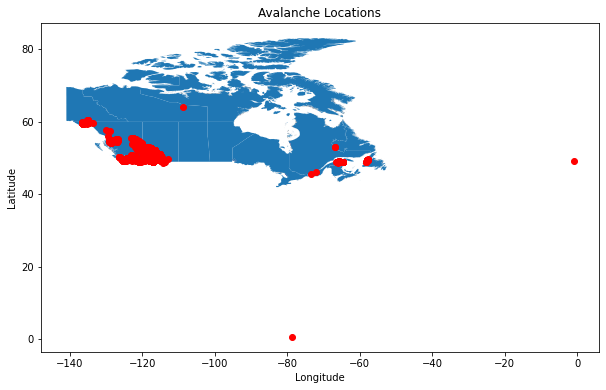

In [27]:
# Create a graph of avalanch locations
fig, ax = plt.subplots(figsize=(10,10))
canada_shapefile.plot(ax=ax)
gdf_avalanche.plot(ax=ax, color = 'red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Avalanche Locations')
plt.show()

As we can see, there are two significant outliers on our data. These errors could have come from the data source itself, the data gathering, or the data cleaning. Regardless source of the outliers, we will remove them from the data set.

In [28]:
# Identify the outlier
gdf_avalanche[gdf_avalanche['latitude'].astype(float) < 20]
# Drop the outlier
gdf_avalanche.drop(index = 1653, inplace = True)

In [29]:
# Identify the outlier
gdf_avalanche[gdf_avalanche['longitude'].astype(float) > -20]
# Drop the outlier
gdf_avalanche.drop(index = 2205, inplace = True)

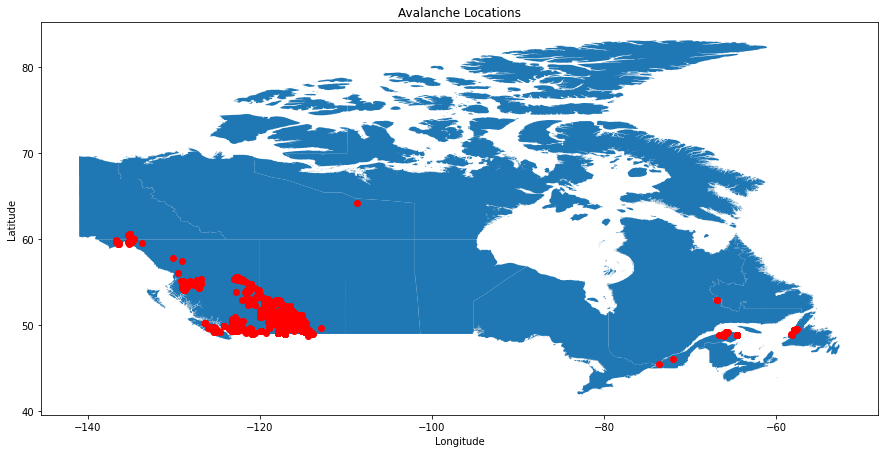

In [30]:
#Plot locations without outlier
fig, ax = plt.subplots(figsize=(15,15))
canada_shapefile.plot(ax=ax)
gdf_avalanche.plot(ax=ax, color = 'red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Avalanche Locations')
plt.savefig('Avalanch_locations.jpeg')
plt.show()

After removing the latitude and longitude errors, we can see that most of our avalanche reports are located in British Columbia and Alberta, with a few in eastern and northern Canada.

## Plotting Weather Stations
To understand where weather stations are located, we will use the same process as mapping the avalanches. This will give us a quick visualization to see if there is good coverage to get accurate weather data for the avalanches.

In [31]:
# Create a dataframe with with the station and the geometry data
gdf_station = gpd.GeoDataFrame(
    station_2016_df, geometry=gpd.points_from_xy(station_2016_df.longitude, station_2016_df.latitude))

In [32]:
# Check
gdf_station.head(5)

,Name,Province,Climate ID,Station ID,latitude,longitude,DLY First Year,DLY Last Year,geometry
12,CHEMAINUS,BRITISH COLUMBIA,1011500,26,48.94,-123.74,1919.0,2021.0,POINT (-123.74000 48.94000)
26,LAKE COWICHAN,BRITISH COLUMBIA,1012055,40,48.83,-124.05,1960.0,2021.0,POINT (-124.05000 48.83000)
28,DISCOVERY ISLAND,BRITISH COLUMBIA,1012475,27226,48.42,-123.23,1997.0,2021.0,POINT (-123.23000 48.42000)
39,ESQUIMALT HARBOUR,BRITISH COLUMBIA,1012710,52,48.43,-123.44,1957.0,2021.0,POINT (-123.44000 48.43000)
44,GALIANO NORTH,BRITISH COLUMBIA,10130MN,55,48.99,-123.57,1975.0,2021.0,POINT (-123.57000 48.99000)


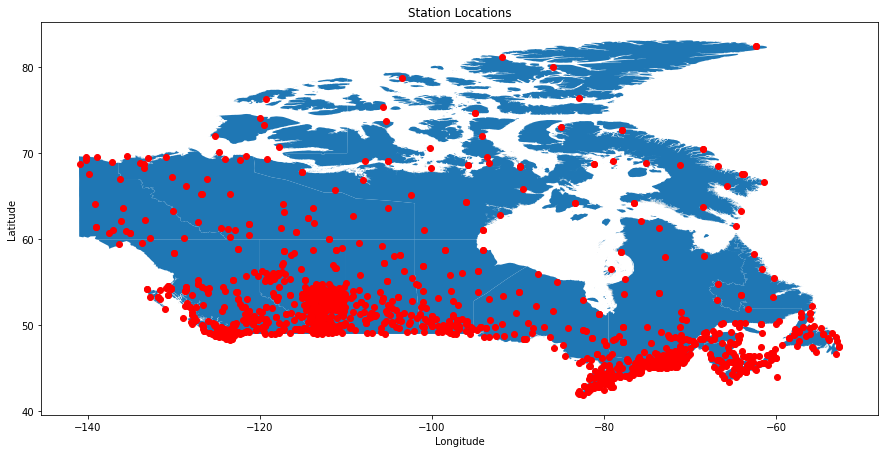

In [33]:
# Plot the station locations
fig, ax = plt.subplots(figsize=(15,15))
canada_shapefile.plot(ax=ax)
gdf_station.plot(ax=ax, color = 'red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station Locations')
plt.show()


From the above graph, we can see a large number of stations located all across Canada. This will give us a good representation of the weather for where the avalanches occurred.

In [34]:
gdf_station.drop(['latitude','longitude'], axis = 1, inplace = True)

## Finding the closest weather station to the avalanche

In [35]:
def ckdnearest(gdA, gdB):
    '''
   Find the closest point in one dataframe to a point in another dataframe
    
    Parameters
    ----------
    gdA: A GeoPandas dataframe
    gdB: A GeoPandas dataframe
    
    Returns
    -------
    ret: A new dataset which has been merged on the closest location
    
    '''

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf


In [36]:
combined_df = ckdnearest(gdf_avalanche, gdf_station)

In [37]:
combined_df.head(5)

,latitude,longitude,weekday,month,day,year,time,geometry,Name,Province,Climate ID,Station ID,DLY First Year,DLY Last Year,dist
0,59.713938,-135.095702,Thursday,May,27,2021,14:00,POINT (-135.09570 59.71394),WHITEHORSE A,YUKON TERRITORY,2101303,50842,2012.0,2021.0,0.996394
1,51.171303,-116.051255,Saturday,May,22,2021,09:00,POINT (-116.05125 51.17130),YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.394426
2,50.427560,-122.473110,Sunday,May,16,2021,11:00,POINT (-122.47311 50.42756),PEMBERTON AIRPORT CS,BRITISH COLUMBIA,1086082,536,1984.0,2021.0,0.282512
3,51.394930,-116.265450,Saturday,May,15,2021,12:00,POINT (-116.26545 51.39493),YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.087115
4,51.395059,-116.257463,Friday,May,14,2021,12:30,POINT (-116.25746 51.39506),YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.093979


In [38]:
# Removes duplicates from the dataframe
clean_combined_df = combined_df.loc[:,~combined_df.columns.duplicated()]

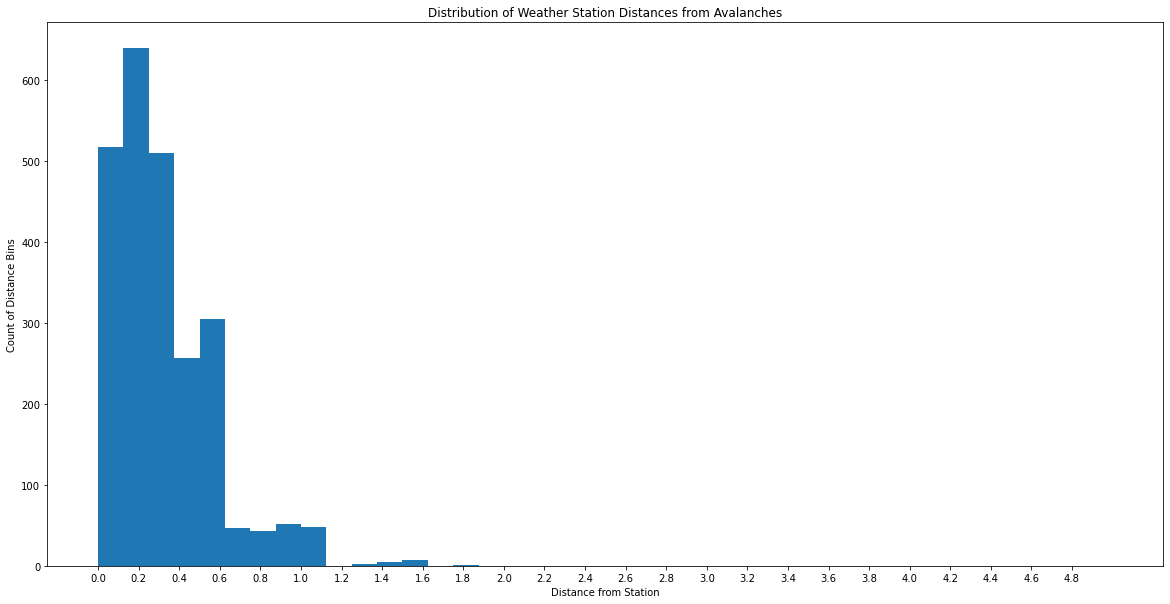

In [162]:
# plot the frequency of distances
plt.figure(figsize=(20,10))
plt.hist(clean_combined_df['dist'], bins = 40, range=(0,5))
plt.title('Distribution of Weather Station Distances from Avalanches')
plt.xlabel('Distance from Station')
plt.ylabel('Count of Distance Bins')
plt.xticks(np.arange(0,5, step=0.20))
plt.show()

As we can see from the graph, most of our data is quite close to the weather. This is good because it means that our historical weather data will be more similar to the weather at the avalanche site. 

In [40]:
# Dropping the geometry column as its no longer needed
cols_to_drop = ['geometry']
clean_combined_df = combined_df.drop(cols_to_drop, axis = 1)

In [41]:
# Check
clean_combined_df.head(5)

,latitude,longitude,weekday,month,day,year,time,Name,Province,Climate ID,Station ID,DLY First Year,DLY Last Year,dist
0,59.713938,-135.095702,Thursday,May,27,2021,14:00,WHITEHORSE A,YUKON TERRITORY,2101303,50842,2012.0,2021.0,0.996394
1,51.171303,-116.051255,Saturday,May,22,2021,09:00,YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.394426
2,50.427560,-122.473110,Sunday,May,16,2021,11:00,PEMBERTON AIRPORT CS,BRITISH COLUMBIA,1086082,536,1984.0,2021.0,0.282512
3,51.394930,-116.265450,Saturday,May,15,2021,12:00,YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.087115
4,51.395059,-116.257463,Friday,May,14,2021,12:30,YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.093979


When we loaded in the data from the CSV is saved the date features as strings. This may cause problems when we try to join our data together; therefore, we will convert them to ints.

In [42]:
# recoding the month feature
clean_combined_df['month'] = clean_combined_df['month'].map({'January':1, 'February':2, 'March': 3, 'April':4, 'May': 5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

In [43]:
# Convert dtypes to int
clean_combined_df['year'] = clean_combined_df['year'].astype('int')
clean_combined_df['month'] = clean_combined_df['month'].astype('int')
clean_combined_df['day'] = clean_combined_df['day'].astype('int')

# Getting the weather data
Now that we have the closest station to the data, we need to get the weather data. This will be done using the wget in Cygwin as highlighted by the `readme` file from the Canada Climate Google Drive.  

To achieve this, we will create a list of every unique station that we can later iterate through in Cygwin.

## Collecting a list of stations 
To create a list of every unique stations we will sort the `Station ID`s and save them to a text file

In [44]:
# Get all the unique stations
list_of_stations = clean_combined_df['Station ID'].unique()

In [45]:
# Sort the list to progress in cygwin is easier to track
list_of_stations.sort()

In [46]:
# check
list_of_stations

array([  145,   162,   181,   209,   225,   257,   277,   283,   323,
         336,   348,   403,   442,   450,   470,   536,   568,   636,
         650,   698,   706,   731,   776,   823,   924,   951,   979,
        1041,  1056,  1070,  1095,  1105,  1106,  1115,  1137,  1142,
        1180,  1186,  1194,  1199,  1207,  1237,  1309,  1340,  1364,
        1367,  1400,  1485,  1504,  2402,  5310,  6610,  6817,  6833,
        6838,  6839,  6840,  6843,  6844,  6938,  8935,  8999, 10104,
       10222, 10223, 10665, 10761, 10890, 10930, 11005, 26850, 27121,
       27195, 27378, 27388, 29733, 30543, 30669, 31067, 43500, 45267,
       46867, 48168, 48208, 48369, 48628, 48688, 48870, 49492, 49548,
       49628, 50028, 50269, 50818, 50842, 51037, 51297, 51517, 51658,
       51818, 52398, 52541], dtype=int64)

In [47]:
with open('stations-11-06-21.txt', 'w') as station_data:
    station_data.write(str(list_of_stations))


It is worth noting that this string was converted into a text the square brackets needed to be drop as well, as the spacing between the numbers required to be adjusted in the text file itself.

### Cygwin Script
The script used to download all of the station date using Cygwin was:  
```
#!/bin/bash
File='stations-11-06-21.txt'
Lines=$(cat $File)
for station in $Lines
    do for year in `seq 2016 2021`
        do for month in `seq 1 1`
            do wget -nv "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=${station}&Year=${year}&Month=${month}&Day=14&timeframe=2&submit= Download+Data" -O ${station}${year}'.csv'
        done
    done
    echo $station
done
```

After running our Cygwin script and bulk download all of the weather data, we have to read them all into one data frame. This will be done by using glob to read the files in a folder, creating a list of the files.

## Importing Weather Data 

In [48]:
# Merge all the CSVs into one dataframe

# Save the path where the weather data CSVs are located
path = r'C:\cygwin64\weather_data' 
all_files = glob.glob(path +'\*.csv')

weather_df = pd.DataFrame()
# Iterate thorugh all of the files appending them to a dataframe
for f in all_files:
    csv = pd.read_csv(f)
    weather_df = weather_df.append(csv)
    print(f, end='\r')

In [49]:
# Check
print(f'weather_df has {weather_df.shape[0]} rows and {weather_df.shape[1]} columns')

weather_df has 227968 rows and 31 columns


In [50]:
# Inspect
weather_df.head(5)

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-01,2016,1,1,NaN,7.9,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
1,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-02,2016,1,2,NaN,7.5,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
2,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-03,2016,1,3,NaN,0.9,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
3,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-04,2016,1,4,NaN,-3.1,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
4,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-05,2016,1,5,NaN,-2.8,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN


Now that we have all the weather data we need to perform some data cleaning and transformation as there are plenty of null values, coded values, and irrelevant columns. To solve this problem we will first drop all the columns that do not contain information that can be used for our analysis.

In [52]:
# Creating a list of the columns to drop
cols_to_drop = ['Snow on Grnd Flag','Dir of Max Gust Flag','Snow on Grnd Flag','Heat Deg Days Flag',
               'Cool Deg Days Flag','Snow on Grnd Flag','Data Quality','Total Precip Flag','Snow on Grnd Flag','Spd of Max Gust Flag','Dir of Max Gust Flag','Cool Deg Days (°C)','Heat Deg Days (°C)','Heat Deg Days Flag','Cool Deg Days Flag','Max Temp Flag','Total Rain Flag','Min Temp Flag','Mean Temp Flag']

# Dropping the columns in place
weather_df.drop(cols_to_drop, inplace = True, axis = 1)

In [53]:
# Check
weather_df.head(5)

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Snow Flag,Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
0,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-01,2016,1,1,7.9,-0.8,3.6,NaN,NaN,M,NaN,NaN,NaN,<31
1,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-02,2016,1,2,7.5,-0.2,3.7,NaN,NaN,M,NaN,NaN,NaN,<31
2,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-03,2016,1,3,0.9,-9.4,-4.3,NaN,NaN,M,NaN,NaN,NaN,<31
3,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-04,2016,1,4,-3.1,-8.6,-5.9,NaN,NaN,M,NaN,NaN,NaN,<31
4,-115.19,50.94,NAKISKA RIDGETOP,305MGFF,2016-01-05,2016,1,5,-2.8,-6.3,-4.6,NaN,NaN,M,NaN,NaN,NaN,<31


In [54]:
# Check
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227968 entries, 0 to 364
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Longitude (x)              227968 non-null  float64
 1   Latitude (y)               227968 non-null  float64
 2   Station Name               227968 non-null  object 
 3   Climate ID                 227968 non-null  object 
 4   Date/Time                  227968 non-null  object 
 5   Year                       227968 non-null  int64  
 6   Month                      227968 non-null  int64  
 7   Day                        227968 non-null  int64  
 8   Max Temp (°C)              179476 non-null  float64
 9   Min Temp (°C)              179845 non-null  float64
 10  Mean Temp (°C)             177113 non-null  float64
 11  Total Rain (mm)            91284 non-null   float64
 12  Total Snow (cm)            91389 non-null   float64
 13  Total Snow Flag            50477

To do binary classification on our problem, we will have to create a new column that will act as our target variable. We will get all the records we have now to 1 indicating that an avalanche occurred, so when we join it with the data, we can set all missing values to 0, indicating an avalanche did not occur.

In [55]:
# Create a target variable and set it to 1
clean_combined_df['avalanche_occured'] = 1

In [56]:
# Check
clean_combined_df.head()

,latitude,longitude,weekday,month,day,year,time,Name,Province,Climate ID,Station ID,DLY First Year,DLY Last Year,dist,avalanche_occured
0,59.713938,-135.095702,Thursday,5,27,2021,14:00,WHITEHORSE A,YUKON TERRITORY,2101303,50842,2012.0,2021.0,0.996394,1
1,51.171303,-116.051255,Saturday,5,22,2021,09:00,YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.394426,1
2,50.427560,-122.473110,Sunday,5,16,2021,11:00,PEMBERTON AIRPORT CS,BRITISH COLUMBIA,1086082,536,1984.0,2021.0,0.282512,1
3,51.394930,-116.265450,Saturday,5,15,2021,12:00,YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.087115,1
4,51.395059,-116.257463,Friday,5,14,2021,12:30,YOHO PARK,BRITISH COLUMBIA,11790J1,6844,1992.0,2021.0,0.093979,1


# Combining the data 
We have massaged our data and transformed it into the correct form we need to join our two datasets together. To ensure we will get the correct data in the right spot, we will join on the station name, year, month, and day.

In [160]:
# Merge the dataframes
new_df = pd.merge(clean_combined_df, weather_df,  how='right', left_on=['Name', 'year', 'month', 'day'], right_on = ['Station Name', 'Year', 'Month', 'Day'])

In [58]:
# filling NA values with 0
new_df['avalanche_occured'] = new_df['avalanche_occured'].fillna(value = 0)

There was an issue trying to join the data sets by `station ID` and `Climate ID` due to this, I had to join them on the station name. This is not ideal. However, it is the only method I could get to work.

In [59]:
# Check
new_df.sample(5)

,latitude,longitude,weekday,month,day,year,time,Name,Province,Climate ID_x,...,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Snow Flag,Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
196606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.8,9.2,19.0,NaN,NaN,NaN,0.0,NaN,16.0,33.0
44115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.5,9.0,17.8,0.0,0.0,NaN,0.0,0.0,NaN,NaN
153643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,-3.0,6.5,NaN,NaN,NaN,0.2,NaN,NaN,NaN
5595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.8,-5.2,3.8,NaN,NaN,NaN,1.8,NaN,NaN,NaN


In [60]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 228422 entries, 0 to 228421
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   2433 non-null    object 
 1   longitude                  2433 non-null    object 
 2   weekday                    2433 non-null    object 
 3   month                      2433 non-null    float64
 4   day                        2433 non-null    float64
 5   year                       2433 non-null    float64
 6   time                       2433 non-null    object 
 7   Name                       2433 non-null    object 
 8   Province                   2433 non-null    object 
 9   Climate ID_x               2433 non-null    object 
 10  Station ID                 2433 non-null    float64
 11  DLY First Year             2433 non-null    float64
 12  DLY Last Year              2433 non-null    float64
 13  dist                 

Now that there are no more null values for `avalanche_occured` we can progress onto the data engineering

## Feature Engineering
After downloading the weather data, it was disappointing to find that there were so many missing values. However, there is some feature engineering that can be done to combat this null data.

In [61]:
# Checking for duplicates
new_df.duplicated().sum()

2

There are 2 duplicates in the dataframe. It is possible there was an issue in the reporting and it was done twice. Since this number is low we will just delete one of the duplicated records.

In [62]:
new_df.drop_duplicates(inplace=True)

In [63]:
# Checking for duplicates
new_df.duplicated().sum()

0

To try and fill some of the gap in the now `Total Snow (cm)` column, we will use information from the `Total Snow Flag` column. If `Total Snow Flag` is an `'M'` it means there was marginal snow. We will convert this to mean there was 1 cm of new snow. The reason for doing this is typically there is more snow at higher elevations in the mountains than at the weather stations.

In [161]:
mask = (new_df['Total Snow Flag'] == 'M')
new_df['Total Snow (cm)'][(new_df['Total Snow Flag'] == 'M')] = 1.0

In [67]:
# Check
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 228420 entries, 0 to 228421
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   2431 non-null    object 
 1   longitude                  2431 non-null    object 
 2   weekday                    2431 non-null    object 
 3   month                      2431 non-null    float64
 4   day                        2431 non-null    float64
 5   year                       2431 non-null    float64
 6   time                       2431 non-null    object 
 7   Name                       2431 non-null    object 
 8   Province                   2431 non-null    object 
 9   Climate ID_x               2431 non-null    object 
 10  Station ID                 2431 non-null    float64
 11  DLY First Year             2431 non-null    float64
 12  DLY Last Year              2431 non-null    float64
 13  dist                 

Since we will be removing some of our temperature data later, we will extract the vital information from it. First, we will create a new variable that shows the range of the temperature that day to see if it has any effect on there being an avalanche.

In [68]:
# Create new column based on range in temperature
new_df['temperature range'] = new_df['Max Temp (°C)'] - new_df['Min Temp (°C)']

Generally, the elevation of the weather stations tended to be relatively low, so to help fill in the missing values of our dataset, we will assume if it were raining at the weather station, it would be snowing at higher elevations in the mountains.

In [69]:
new_df['Total Snow (cm)'].fillna(new_df['Total Precip (mm)'], inplace = True)

In [70]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 228420 entries, 0 to 228421
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   2431 non-null    object 
 1   longitude                  2431 non-null    object 
 2   weekday                    2431 non-null    object 
 3   month                      2431 non-null    float64
 4   day                        2431 non-null    float64
 5   year                       2431 non-null    float64
 6   time                       2431 non-null    object 
 7   Name                       2431 non-null    object 
 8   Province                   2431 non-null    object 
 9   Climate ID_x               2431 non-null    object 
 10  Station ID                 2431 non-null    float64
 11  DLY First Year             2431 non-null    float64
 12  DLY Last Year              2431 non-null    float64
 13  dist                 

After imputing some of the data into `Total Snow (cm)` is is now time to drop all the records that still do not have a value so we can use this column in the models.

In [71]:
# Remove those records
new_df.dropna(subset = ['Total Snow (cm)'], inplace = True)

In [72]:
# Check
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 178673 entries, 0 to 228218
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   2008 non-null    object 
 1   longitude                  2008 non-null    object 
 2   weekday                    2008 non-null    object 
 3   month                      2008 non-null    float64
 4   day                        2008 non-null    float64
 5   year                       2008 non-null    float64
 6   time                       2008 non-null    object 
 7   Name                       2008 non-null    object 
 8   Province                   2008 non-null    object 
 9   Climate ID_x               2008 non-null    object 
 10  Station ID                 2008 non-null    float64
 11  DLY First Year             2008 non-null    float64
 12  DLY Last Year              2008 non-null    float64
 13  dist                 

In [73]:
# Drop columns
new_df.drop(['Total Rain (mm)','Total Precip (mm)'], axis = 1, inplace = True)

In [74]:
new_df.sample(20)

,latitude,longitude,weekday,month,day,year,time,Name,Province,Climate ID_x,...,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Snow (cm),Total Snow Flag,Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),temperature range
104677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29,3.2,-9.6,-3.2,0.0,NaN,23.0,25.0,56.0,12.8
163485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,5.1,0.6,2.9,0.0,NaN,NaN,10.0,42,4.5
179433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,21.2,8.1,14.7,0.0,NaN,NaN,NaN,NaN,13.1
169941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25,25.0,11.2,18.1,1.0,M,NaN,20.0,41,13.8
145494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,32.1,14.7,23.4,1.0,M,NaN,NaN,<31,17.4
150883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24,17.1,3.1,10.1,0.0,NaN,7.0,24.0,43.0,14.0
16301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29,25.9,18.1,22.0,0.0,NaN,NaN,NaN,NaN,7.8
168237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,1.2,-0.5,0.4,0.0,NaN,0.0,NaN,NaN,1.7
14980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16,-2.5,-5.5,-4.0,13.0,NaN,88.0,NaN,NaN,3.0
15475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24,10.6,0.2,5.4,1.0,M,NaN,17.0,33,10.4


### Removing Unuseable columns
Unfortunately, the weather stations' reliability was quite bad, causing a few columns to have too many null values to impute. Due to this, these columns need to be removed.

In [75]:
# Create list of columns that need to be removed
cols_to_remove = ['Climate ID_x','Date/Time','Total Snow Flag','Longitude (x)','Latitude (y)','DLY First Year','DLY Last Year','dist','year','month','day','Name','Province']

In [76]:
# Drop columns
new_df.drop(cols_to_remove,axis = 1, inplace = True)

In [77]:
# Check
new_df.head(5)

,latitude,longitude,weekday,time,Station ID,avalanche_occured,Station Name,Climate ID_y,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Snow (cm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),temperature range
0,NaN,NaN,NaN,NaN,NaN,0.0,NAKISKA RIDGETOP,305MGFF,2016,1,1,7.9,-0.8,3.6,1.0,NaN,NaN,<31,8.7
1,NaN,NaN,NaN,NaN,NaN,0.0,NAKISKA RIDGETOP,305MGFF,2016,1,2,7.5,-0.2,3.7,1.0,NaN,NaN,<31,7.7
2,NaN,NaN,NaN,NaN,NaN,0.0,NAKISKA RIDGETOP,305MGFF,2016,1,3,0.9,-9.4,-4.3,1.0,NaN,NaN,<31,10.3
3,NaN,NaN,NaN,NaN,NaN,0.0,NAKISKA RIDGETOP,305MGFF,2016,1,4,-3.1,-8.6,-5.9,1.0,NaN,NaN,<31,5.5
4,NaN,NaN,NaN,NaN,NaN,0.0,NAKISKA RIDGETOP,305MGFF,2016,1,5,-2.8,-6.3,-4.6,1.0,NaN,NaN,<31,3.5


## Sub-sample of non-avalanche data 
Since my data range is from 2016 to 2021, the number of non-avalanche days dramatically outweighs the number of days there was an avalanche. One of the options to fix the class imbalance would be to boost the avalanche days. However, since this would require too many duplications of the data, I will elect to take a sub-sample of the non-avalanche days

In [78]:
# filling NA values with 0
new_df['avalanche_occured'].fillna(value= 0, inplace = True)

In [79]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 178673 entries, 0 to 228218
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   2008 non-null    object 
 1   longitude                  2008 non-null    object 
 2   weekday                    2008 non-null    object 
 3   time                       2008 non-null    object 
 4   Station ID                 2008 non-null    float64
 5   avalanche_occured          178673 non-null  float64
 6   Station Name               178673 non-null  object 
 7   Climate ID_y               178673 non-null  object 
 8   Year                       178673 non-null  int64  
 9   Month                      178673 non-null  int64  
 10  Day                        178673 non-null  int64  
 11  Max Temp (°C)              172693 non-null  float64
 12  Min Temp (°C)              172147 non-null  float64
 13  Mean Temp (°C)       

In [80]:
# Take sample of 
incident_df = new_df.groupby('avalanche_occured').apply(lambda x: x.sample(n=2008)).reset_index(drop = True)

In [81]:
# Check
incident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   2008 non-null   object 
 1   longitude                  2008 non-null   object 
 2   weekday                    2008 non-null   object 
 3   time                       2008 non-null   object 
 4   Station ID                 2008 non-null   float64
 5   avalanche_occured          4016 non-null   float64
 6   Station Name               4016 non-null   object 
 7   Climate ID_y               4016 non-null   object 
 8   Year                       4016 non-null   int64  
 9   Month                      4016 non-null   int64  
 10  Day                        4016 non-null   int64  
 11  Max Temp (°C)              3934 non-null   float64
 12  Min Temp (°C)              3933 non-null   float64
 13  Mean Temp (°C)             3907 non-null   float

In [85]:
# Drop unneeded columns
incident_df.drop(['Dir of Max Gust (10s deg)','Spd of Max Gust (km/h)','Snow on Grnd (cm)',
                  'latitude','longitude','weekday','time',
                  'Station ID','Station Name','Climate ID_y','Year','Month','Day'], axis = 1, inplace = True)

In [86]:
# Check
incident_df.head(5)

,avalanche_occured,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Snow (cm),temperature range
0,0.0,6.0,0.0,3.0,0.0,6.0
1,0.0,23.1,13.5,18.3,1.0,9.6
2,0.0,9.6,-4.5,2.6,1.0,14.1
3,0.0,9.6,6.6,8.1,0.0,3.0
4,0.0,NaN,NaN,NaN,0.0,NaN


## Checking Multi-Collinearity 
With 3 different columns related to the temperature we will check to see how corrilated they are.

In [87]:
ava_corr = new_df.corr()
ava_corr

,Station ID,avalanche_occured,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Snow (cm),Snow on Grnd (cm),Dir of Max Gust (10s deg),temperature range
Station ID,1.000000,NaN,0.017004,-0.037806,-0.017062,-0.110805,-0.133932,-0.130297,0.016034,0.051688,-0.191521,0.053092
avalanche_occured,NaN,1.000000,0.092967,-0.050672,0.002093,-0.095384,-0.086908,-0.095520,0.036011,0.108289,0.011650,-0.043509
Year,0.017004,0.092967,1.000000,-0.125657,-0.010634,-0.066441,-0.080991,-0.076061,0.062122,0.079801,0.037937,0.004460
Month,-0.037806,-0.050672,-0.125657,1.000000,0.010356,0.168815,0.235043,0.205913,-0.001273,-0.278064,0.018293,-0.058747
Day,-0.017062,0.002093,-0.010634,0.010356,1.000000,0.041009,0.042973,0.043431,-0.003350,-0.013110,0.017476,0.009643
Max Temp (°C),-0.110805,-0.095384,-0.066441,0.168815,0.041009,1.000000,0.863228,0.970745,-0.124351,-0.380887,0.033582,0.533664
Min Temp (°C),-0.133932,-0.086908,-0.080991,0.235043,0.042973,0.863228,1.000000,0.958893,-0.044250,-0.361124,-0.013951,0.033754
Mean Temp (°C),-0.130297,-0.095520,-0.076061,0.205913,0.043431,0.970745,0.958893,1.000000,-0.089693,-0.385615,0.011954,0.316156
Total Snow (cm),0.016034,0.036011,0.062122,-0.001273,-0.003350,-0.124351,-0.044250,-0.089693,1.000000,0.223720,-0.056998,-0.170530
Snow on Grnd (cm),0.051688,0.108289,0.079801,-0.278064,-0.013110,-0.380887,-0.361124,-0.385615,0.223720,1.000000,0.054986,-0.139559


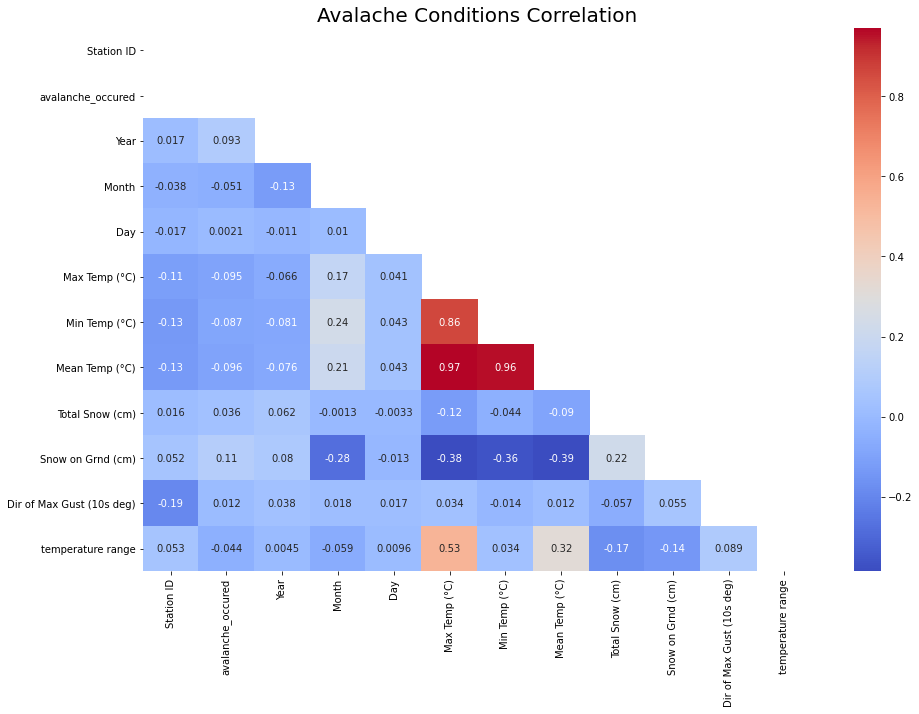

In [88]:
# Correlation of the variables in a heatmap
plt.figure(figsize=(15,10))
matrix = np.triu(ava_corr)
sns.heatmap(ava_corr, annot=True, mask=matrix, cmap='coolwarm')
plt.title('Avalache Conditions Correlation', size=20)
plt.show()

As we can see, the temperature features are highly correlated with each other. This is understandable because as the mean temperature increases typically, so would the max and min temperatures.

In [89]:
# Drop the corrlated temperature data
clean_incident_df = incident_df.drop(['Max Temp (°C)','Min Temp (°C)'], axis = 1)

In [90]:
# Check
clean_incident_df.head(5)

,avalanche_occured,Mean Temp (°C),Total Snow (cm),temperature range
0,0.0,3.0,0.0,6.0
1,0.0,18.3,1.0,9.6
2,0.0,2.6,1.0,14.1
3,0.0,8.1,0.0,3.0
4,0.0,NaN,0.0,NaN


In [136]:
clean_incident_df.isna().sum()

avalanche_occured    0
Mean Temp (°C)       0
Total Snow (cm)      0
temperature range    0
dtype: int64

In [135]:
clean_incident_df.dropna(inplace = True)

# Model Building
To keep it simple I will be focusing on linear models for this project. If I had more time I would explore training a neural network to do the predictions, however I do not have time. Since this is a simple binary classification problem a linear classifier should be able to handle the data well.

In [137]:
# Get target
y = clean_incident_df['avalanche_occured']
# Get features
X = clean_incident_df.drop(['avalanche_occured'], axis = 1)

In [138]:
# Check
print(f'avalanche_df has {X.shape[0]} rows and {X.shape[1]} columns')
print(f'avalanche_df has {y.shape[0]} rows')

avalanche_df has 3907 rows and 3 columns
avalanche_df has 3907 rows


To make sure we can test our results we will perform a test train split, reserving 20% of the data as the test set. Since we have a relatively small dataset I am hesitant to increase the size of the test set to much and take information away from the train set.

In [139]:
# Split Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [140]:
# Check
print(f'The train set has {X_train.shape[0]} rows and {X_train.shape[1]} columns')

The train set has 3125 rows and 3 columns


In [141]:
print(f'The test set has {X_test.shape[0]} rows and {X_test.shape[1]} columns')

The test set has 782 rows and 3 columns


In [142]:
# Placeholders for the series of steps we're using

pipe_estimators = [('scaling', StandardScaler()),
                   ('classifier', SVC())]

avalanche_pipe = Pipeline(pipe_estimators)

In [143]:
# SVMs, DTs, KNNs

logit_gird = {'classifier': [LogisticRegression()],
              'scaling': [None, StandardScaler(),MinMaxScaler()],
              'classifier__C': [10**i for i in range(-3, 3)]}

svm_grid = {'classifier': [SVC()],
            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
            'scaling': [None, StandardScaler(),MinMaxScaler()],
            'classifier__C': [10**i for i in range(-3, 3)]}


DT_grid = {'classifier': [DecisionTreeClassifier()],
            'scaling': [None, MinMaxScaler()],
            'classifier__max_depth': [2,3,4,5,6,7]}


KNN_grid = {'classifier': [KNeighborsClassifier()],
            'scaling': [StandardScaler(), MinMaxScaler(), None],
            'classifier__n_neighbors': [6, 10, 16, 17]}


param_grid = [svm_grid, 
              DT_grid,
              KNN_grid,
              logit_gird]

In [144]:
# Instantiate
avalanche_gridsearch = GridSearchCV(avalanche_pipe, param_grid=param_grid, cv=5, verbose=2)

In [145]:
# Fit
avalanche_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier

[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler

[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0

[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.4s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.4s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.4s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.4s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.4s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classif

[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   1.7s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   1.9s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   1.8s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   1.9s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   2.0s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.2s
[CV] EN

[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  12.9s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  13.7s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  14.6s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  14.5s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  15.0s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.6s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.6s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.6s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.6

[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=5, scaling=None; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=5, scaling=None; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=5, scaling=None; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=5, scaling=None; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(), classifier__max_depth=5, scaling=None; total time=   0.0s
[CV] END classifier=Deci

[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=None; total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=17, scaling=None; 

[CV] END classifier=LogisticRegression(), classifier__C=100, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=100, scaling=MinMaxScaler(); total time=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [SVC()],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid', 'precomputed'],
                          'scaling': [None, StandardScaler(), MinMaxScaler()]},
                         {'classifier': [DecisionTreeClassifier(max_depth=3)],
                          'classifier__max_depth': [2, 3, 4, 5, 6, 7],
                          'scaling': [None, MinMaxScaler()]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [6, 10, 16, 17],
                          'scaling': [StandardScaler(), MinMaxScaler(), None]},
                         {'classifier': [LogisticRegression()],
 

In [146]:
# get best params
avalanche_gridsearch.best_params_

{'classifier': DecisionTreeClassifier(max_depth=3),
 'classifier__max_depth': 3,
 'scaling': None}

In [148]:
# Score
print(f'the train data had an accuracy of {avalanche_gridsearch.best_estimator_.score(X_train, y_train)}')
print(f'the test data had an accuracy of {avalanche_gridsearch.best_estimator_.score(X_test, y_test)}')

the train data had an accuracy of 0.76672
the test data had an accuracy of 0.7710997442455243


While the accuracy score of this initial model is good, another aspect that can cause avalanches is freezing and thawing. To try and measure this, we will look to see if the `Min Temp (°C)` was below zero and the `Max Temp (°C)` was above zero.

In [149]:
# Creating a function to check the freeze thaw
def condition(arg):
    if arg['Min Temp (°C)'] < 0 and arg['Max Temp (°C)'] > 0:
        return 1
    else:
        return 0

In [150]:
# Apply condition to dataset
clean_incident_df['Freeze Thaw'] = incident_df.apply(condition, axis = 1)

In [151]:
# Check
clean_incident_df.head()

,avalanche_occured,Mean Temp (°C),Total Snow (cm),temperature range,Freeze Thaw
0,0.0,3.0,0.0,6.0,0
1,0.0,18.3,1.0,9.6,0
2,0.0,2.6,1.0,14.1,1
3,0.0,8.1,0.0,3.0,0
5,0.0,-5.0,0.0,14.0,1


In [152]:
# Set the target and features after changes
y = clean_incident_df['avalanche_occured']
X = clean_incident_df.drop(['avalanche_occured'], axis = 1)

In [153]:
# Set train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

In [154]:
# Perform GridSearchCV
avalanche_gridsearch2 = GridSearchCV(avalanche_pipe, param_grid=param_grid, cv=5, verbose=2)
avalanche_gridsearch2.fit(X_train, y_train)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.001, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier

[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=None; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear, scaling=StandardScaler

[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=None; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0

[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.3s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.3s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.3s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.4s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=None; total time=   0.3s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=SVC(), classifier__C=1, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.0s
[CV] END classif

[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   3.2s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   1.5s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   1.6s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   1.8s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=None; total time=   1.7s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.2s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] END classifier=SVC(), classifier__C=10, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.1s
[CV] EN

[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  15.6s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  12.1s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  12.7s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  14.3s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=None; total time=  12.3s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.6s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.6s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.6s
[CV] END classifier=SVC(), classifier__C=100, classifier__kernel=linear, scaling=StandardScaler(); total time=   0.7

[CV] END classifier=DecisionTreeClassifier(max_depth=3), classifier__max_depth=4, scaling=None; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(max_depth=3), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(max_depth=3), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(max_depth=3), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(max_depth=3), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(max_depth=3), classifier__max_depth=4, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(max_depth=3), classifier__max_depth=5, scaling=None; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(max_depth=3), classifier__max_depth=5, scaling=None; total time=   0.0s
[CV] END classifier=DecisionTr

[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=None; total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=None; total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=None; total time=   0.0s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=16, scaling=None; total time=   0.0s
[CV] 

[CV] END classifier=LogisticRegression(), classifier__C=10, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=10, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=10, scaling=StandardScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=10, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=10, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=10, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=10, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=10, scaling=MinMaxScaler(); total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=100, scaling=None; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=100, scaling=None; t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [SVC(C=10)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid', 'precomputed'],
                          'scaling': [None, StandardScaler(), MinMaxScaler()]},
                         {'classifier': [DecisionTreeClassifier(max_depth=3)],
                          'classifier__max_depth': [2, 3, 4, 5, 6, 7],
                          'scaling': [None, MinMaxScaler()]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [6, 10, 16, 17],
                          'scaling': [StandardScaler(), MinMaxScaler(), None]},
                         {'classifier': [LogisticRegression()

In [155]:
avalanche_gridsearch2.best_params_

{'classifier': SVC(C=10),
 'classifier__C': 10,
 'classifier__kernel': 'rbf',
 'scaling': None}

In [156]:
print(avalanche_gridsearch2.best_estimator_.score(X_train, y_train))
print(avalanche_gridsearch2.best_estimator_.score(X_test, y_test))

0.76928
0.7723785166240409


## Final Model 
As we can see above, adding the `Freeze Thaw` extra feature added a little more accuracy to the data set. According to the gridsearchCV, the most accurate model was SVC with a C = 10 and an `rbf` kernel. While researching avalanche prediction, I found an [article](https://www.cambridge.org/core/journals/annals-of-glaciology/article/applying-machine-learning-methods-to-avalanche-forecasting/FBCEFDC8F6A8A81B40369AAB8BAA8B93) published by the Cambridge University Press, which also found SVCs the be the most accurate model.

In [157]:

svc =  SVC(kernel='rbf', C=10)
svc.fit(X_train, y_train)
print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))

0.76928
0.7723785166240409


<Figure size 1440x1440 with 0 Axes>

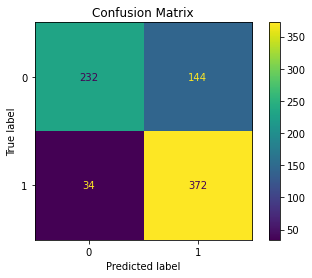

In [158]:
y_pred = svc.predict(X_test)
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(20,20))
ConfusionMatrixDisplay(cf_matrix).plot()
plt.title('Confusion Matrix')
plt.savefig('ConfusionMatrix.jpeg', dpi = 600)
plt.show()

## Model Performance
With a final model accuracy of 0.74 our model does fairly well at predicting whether or not there will be an avalance. Interestingly our model tends to be more caustious predicts false negatives when it tends to get it wrong. Interestingly, while doing research on the topic of machine learning I came across a study from the Annals of Glaciology published by the Cambridge University Press which also found SVM's to show promise however, they admit it still needs work. 

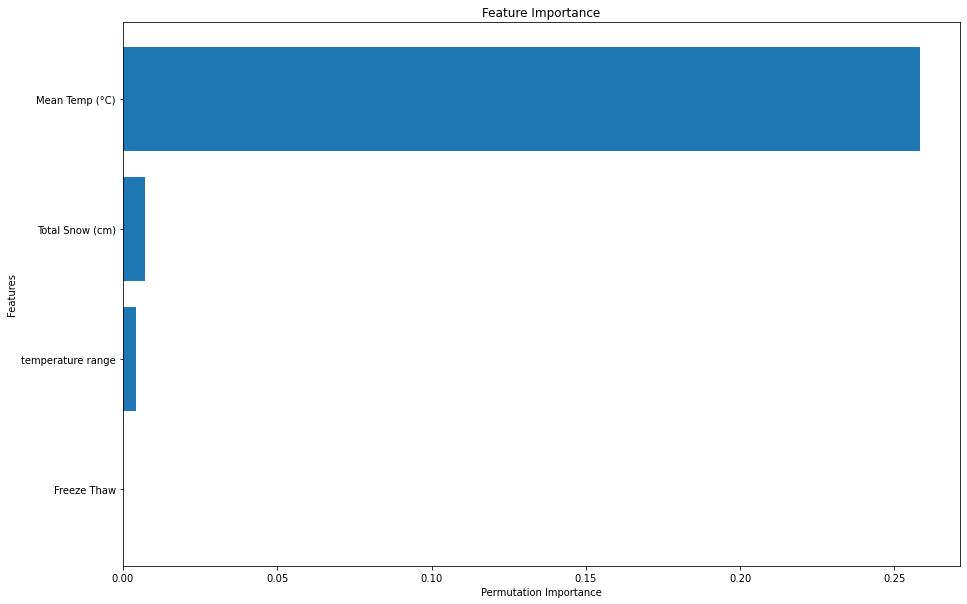

In [159]:

svc =  SVC(kernel='rbf', C=10)
svc.fit(X_train, y_train)

perm_importance = permutation_importance(svc, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(15,10))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

## Feature Importance
When looking at the feature importance, it is a bit interesting to see how important `Mean Temp (cm)` is to the predictability of my model. This might be a result of having summer data included non-avalanche data. While it is not technically wrong to use summer data for avalanche predictions, it does bring into question the model's reliability for real-world use.

# Summary
The first step in the project was to create a CSV from the MIN reporting system using selenium to create an automated browser. Once the avalanche information was acquired, the location of the avalanche needed to be cross-referenced with a list of weather stations tracked by the Canadian government to get the nearest station. Next, a bulk download of weather data was done from those stations and joined with the avalanche data. A sub-sample of the non-avalanche day data was taken to ensure an even class balance. After hyperparameter optimization, I found an SVM with non-scaled data, an 'rbf' kernel, and C = 10 was the most accurate model, with `Mean Temp (cm)` being the most important feature.